In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
sys.path.extend(['/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/src'])
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines, set_plotting_params
from null_models.geomsurr import geomsurr
set_plotting_params()

# Protocol Pathway B: Average Controllability

### Load adjacency

In [2]:
# directory where data is stored
datadir = "/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/data"
resultsdir = "/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/results"
adjacency_file = "pnc_schaefer200_Am.npy"

In [3]:
# load adjacency matrix
adjacency = np.load(os.path.join(datadir, adjacency_file))
n_nodes = adjacency.shape[0]
print(adjacency.shape)

(200, 200)


### Normalize adjacency

In [4]:
# normalize
# system = 'discrete'
system = "continuous"
adjacency_norm = matrix_normalization(adjacency, system=system, c=1)

### Compute average controllability

In [5]:
# compute average controllability
average_controllability = ave_control(adjacency_norm, system=system)

### Plot average controllability

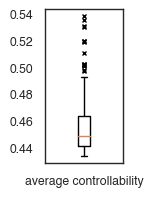

In [6]:
# plot distribution of values
f, ax = plt.subplots(figsize=(1, 2))
ax.boxplot(average_controllability, flierprops={"marker": "x", "markersize": 3})
ax.set_xticklabels(["average controllability"])
if system == "discrete":
    ax.set_yscale("log")
f.savefig(
    os.path.join(resultsdir, "ave_ctrb_boxplot.svg"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

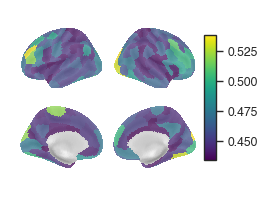

In [7]:
# rank data for plotting
plot_rank = False
if plot_rank:
    data = sp.stats.rankdata(average_controllability)
    fig_label = "ave_ctrb_rank_brainplot.png"
else:
    data = average_controllability
    fig_label = "ave_ctrb_brainplot.png"

# plot states on brain surface
lh_annot_file = os.path.join(datadir, 'schaefer_parc', 'fsaverage5', 'lh.Schaefer2018_200Parcels_7Networks_order.annot')
rh_annot_file = os.path.join(datadir, 'schaefer_parc', 'fsaverage5', 'rh.Schaefer2018_200Parcels_7Networks_order.annot')
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
cmap = "viridis"

f = surface_plot(
    data=data,
    lh_annot_file=lh_annot_file,
    rh_annot_file=rh_annot_file,
    fsaverage=fsaverage,
    order="lr",
    cmap="viridis",
)
f.savefig(
    os.path.join(resultsdir, fig_label), dpi=600, bbox_inches="tight", pad_inches=0.01
)

## Null network models

In [8]:
# null networks
centroids = pd.read_csv(
    os.path.join(datadir, "pnc_schaefer200_centroids.csv")
)  # load coordinates of nodes
centroids.set_index("node_names", inplace=True)
print(centroids.head())

distance_matrix = distance.pdist(
    centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

            vox_x  vox_y  vox_z
node_names                     
LH_Vis_1      121    149     69
LH_Vis_2      123    174     65
LH_Vis_3      143    166     70
LH_Vis_4      107    164     74
LH_Vis_5      124    192     66


In [9]:
run = False
if run:
    # run permutation
    n_perms = 5000  # number of permutations

    # container for null distribution
    ave_ctrb_null = np.zeros((n_perms, n_nodes))

    for perm in tqdm(np.arange(n_perms)):
        # rewire adjacency matrix using geomsurr
        _, _, Wssp = geomsurr(W=adjacency, D=distance_matrix, seed=perm)

        # compute average controllability
        Wssp = matrix_normalization(Wssp, system=system)
        ave_ctrb_null[perm, :] = ave_control(Wssp, system=system)

    np.save(os.path.join(resultsdir, "ac_null_ssp"), ave_ctrb_null)
else:
    pass

In [10]:
run = False
if run:
    ave_ctrb_null = np.load(os.path.join(resultsdir, "ac_null_ssp.npy"))

    # calculate p-values
    p_vals_ssp = np.zeros(n_nodes)

    for node in tqdm(np.arange(n_nodes)):
        # version='standard' will calculate the number of times the null is larger than the observed value
        # version='reverse' will calculate the number of times the null is smaller than the observed value
        p_vals_ssp[node] = get_null_p(
            average_controllability[node], ave_ctrb_null[:, node], version="standard"
        )

    p_vals_ssp = get_fdr_p(p_vals_ssp)  # correct p values for multiple comparisons

    f, ax = plt.subplots(1, 4, figsize=(7, 2))
    data = average_controllability.copy()
    data[p_vals_ssp >= 0.05] = np.nan
    f = surface_plot(
        data=data,
        lh_annot_file=lh_annot_file,
        rh_annot_file=rh_annot_file,
        fsaverage=fsaverage,
        order="lr",
        cmap="viridis",
    )
    f.savefig(
        os.path.join(resultsdir, "ac_network_null.png"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )

In [11]:
if run:
    # print(data[~np.isnan(data)])
    idx = np.where(data == data[~np.isnan(data)][0])[0][0]
    print(p_vals_ssp[idx])
    f, ax = plt.subplots(figsize=(3, 2))

    null_plot(
        observed=average_controllability[idx],
        null=ave_ctrb_null[:, idx],
        p_val=p_vals_ssp[idx],
        xlabel="sequence-preserving",
        ax=ax,
    )
    f.tight_layout()
    f.savefig(
        os.path.join(resultsdir, "ac_network_null_single_node.svg"),
        dpi=600,
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()